In [1]:
# -*- coding: utf-8 -*-
"""
@authors: salmon, gramfort, bellet
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

plt.close('all')


###############################################################################
#            Toy dataset
###############################################################################

n_samples = 1000
n_features = 100
n_iter = 1000  # number of iterations
gamma = 0.01  # suggested step size


"""def gamma(t):
    return 1. / (100 + t)"""

X_toy = np.random.randn(n_samples, n_features)
epsilon_toy = np.random.randn(n_samples) * 1e-5
w_target = np.ones(n_features)
y_toy = X_toy.dot(w_target) + epsilon_toy


# Initialize w with just zeros
w_ini = np.zeros(X_toy.shape[1] + 1)

loss = 'mse'
# loss = 'hinge'  # QUESTION 4


############################################################################
#                Stochastic gradient
############################################################################


def decision_function(X, w):
    """ fonction de prediction a partir d'un vecteur directeur"""
    return np.dot(X, w[1:]) + w[0]


def predict(X, w):
    """ fonction de prediction de classe a partir d'un vecteur directeur"""
    return np.sign(decision_function(X, w))


def stochastic_gradient(X, y, gamma, n_iter, w_ini, loss="mse",
                        alpha=0, average=False, t0=-1):
    """Stochastic gradient algorithm

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The targets.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size (QUESTION 5).
    n_iter : int
        The number of iterations
    w_ini : array, shape (n_features + 1,)
        The initial value of w.
    loss : str
        The type of loss function to use, e.g. "hinge" ou "mse".
    alpha : float
        The regularization coefficient.
        QUESTION 3
    average : bool
        Do an averaged stochastic gradient.
        QUESTION 2

    Returns
    -------
    w : array, shape (n_features + 1,)
        The final weights.
    all_w : array, shape (n_iter, n_features + 1)
        The weights across iterations.
    pobj : array, shape (n_iter,)
        The evolution of the cost function across iterations.
    """
    n_samples = X.shape[0]
    X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
    all_w = np.zeros((n_iter, w_ini.size))
    all_w[0] = w_ini
    w = w_ini.copy()
    pobj = np.zeros(n_iter)
    avg_pobj = np.zeros(n_iter)
    avg_w = 0

    if not callable(gamma):
        # Turn gamma to a function for QUESTION ???

        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        idx = np.random.randint(n_samples)
        if loss == "mse":
            pobj[t] = 0.5 * np.mean((y - np.dot(X, w)) ** 2)
            gradient = (X[idx]@w - y[idx])*X[idx]; # QUESTIONS 2 et 3
        elif loss == "hinge":
            pobj[t] = np.mean(np.max((np.zeros(y.shape),np.ones(y.shape)-y*np.dot(X, w)), axis=0))
            pregrad = y[idx]*(X[idx]@w)
            if pregrad > 1:
                gradient = 0
            else:
                gradient = -y[idx]*X[idx]
        w -= gamma_func(t) * gradient + alpha * w
        
        if average is True:
            if t==t0+1:
                avg_w = w
            if t>t0:
                avg_w = (t-t0)*avg_w/(t-t0+1) + w/(t-t0+1)
                if loss == "mse":
                    avg_pobj[t] = 0.5 * np.mean((y - np.dot(X, avg_w)) ** 2)
                elif loss == "hinge":
                    avg_pobj[t] = np.mean(np.max((np.zeros(y.shape),np.ones(y.shape)-y*np.dot(X, avg_w)), axis=0))
        all_w[t] = w
    return w, all_w, pobj, avg_w, avg_pobj

_, _, pobj, _, _ = stochastic_gradient(X_toy, y_toy, gamma, n_iter, w_ini,
                                         loss=loss, alpha=0, average=False)

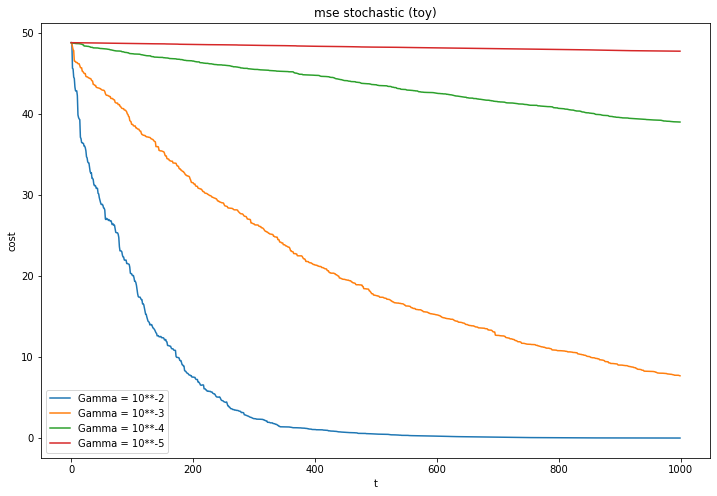

In [2]:
plt.figure(figsize=(12,8))
for g in range(-2,-6,-1):
    _, _, pobj, _, _ = stochastic_gradient(X_toy, y_toy, 10**g, n_iter, w_ini,
                                         loss=loss, alpha=0, average=False)
    plt.plot(pobj, label=f"Gamma = 10**{g}")
plt.xlabel('t')
plt.ylabel('cost')
plt.legend()
plt.title('%s stochastic (toy)' % loss)
plt.show()

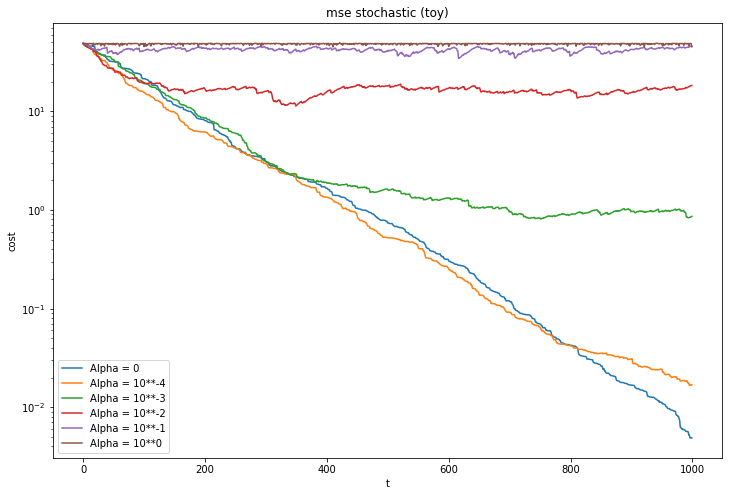

In [3]:
plt.figure(figsize=(12,8))
_, _, pobj, _, _ = stochastic_gradient(X_toy, y_toy, .01, n_iter, w_ini,
                                        loss=loss, alpha=0, average=False)
plt.plot(pobj, label=f"Alpha = 0")
for alpha in range(-4,1,1):
    _, _, pobj, _, _ = stochastic_gradient(X_toy, y_toy, .01, n_iter, w_ini,
                                         loss=loss, alpha=10**alpha, average=False)
    plt.plot(pobj, label=f"Alpha = 10**{alpha}")
plt.xlabel('t')
plt.ylabel('cost')
plt.yscale('log')
plt.legend()
plt.title('%s stochastic (toy)' % loss)
plt.show()

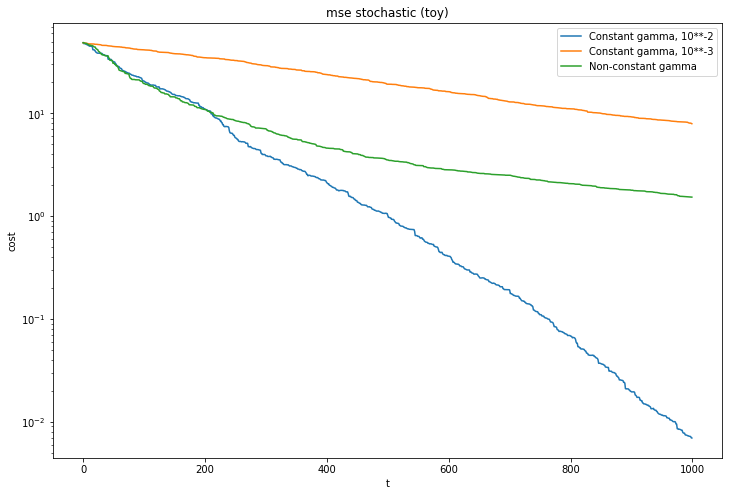

In [4]:
def gamma_f(t):
    return 1. / (100 + t)

plt.figure(figsize=(12,8))
_, _, pobj, _, _ = stochastic_gradient(X_toy, y_toy, 10**-2, n_iter, w_ini,
                                        loss=loss, alpha=0, average=False)
plt.plot(pobj, label=f"Constant gamma, 10**-2")
_, _, pobj, _, _ = stochastic_gradient(X_toy, y_toy, 10**-3, n_iter, w_ini,
                                        loss=loss, alpha=0, average=False)
plt.plot(pobj, label=f"Constant gamma, 10**-3")
_, _, pobj, _, _ = stochastic_gradient(X_toy, y_toy, gamma_f, n_iter, w_ini,
                                        loss=loss, alpha=0, average=False)
plt.plot(pobj, label=f"Non-constant gamma")

plt.xlabel('t')
plt.ylabel('cost')
plt.yscale("log")
plt.legend()
plt.title('%s stochastic (toy)' % loss)
plt.show()

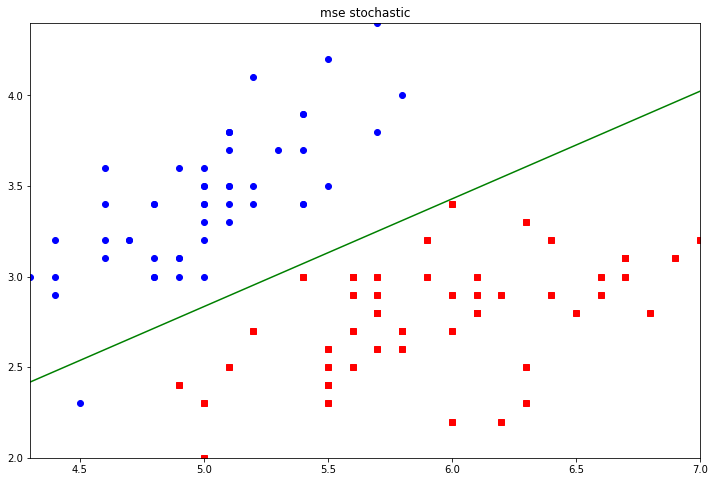

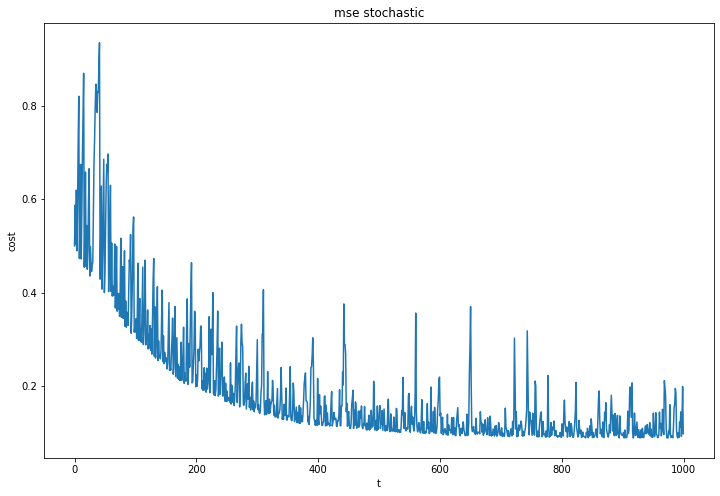

In [26]:
############################################################################
#            Loading and visualizing the data
############################################################################

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Make the problem binary
X = X[y < 2]
y = y[y < 2]
y[y == 0] = -1
X = X[:, :2]

# A function for vizualizing the data and classification given by w
def plot_2d(X, y, w=None):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""
    symlist = ['o', 's', '+', 'x', 'D', '*', 'p', 'v', '-', '^']
    collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
               'fuchsia']

    labs = np.unique(y)
    idxbyclass = [y == labs[i] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.plot(X[idxbyclass[i], 0], X[idxbyclass[i], 1],
                 color=collist[i % len(collist)], ls='None',
                 marker=symlist[i % len(symlist)])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    mx = np.min(X[:, 0])
    maxx = np.max(X[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=1.)

############################################################################
#            Displaying labeled data
############################################################################


# QUESTION 8
gamma = 0.01  # step size
n_iter = 1000  # number of iterations

loss = 'mse'
# loss = 'hinge'  # QUESTION 11

# Initialize w with just zeros
w_ini = np.zeros(X.shape[1] + 1)

w, all_w, pobj, _, _ = stochastic_gradient(X, y, gamma, n_iter, w_ini, loss=loss)

plt.figure(figsize=(12,8))
plot_2d(X, y, w)
plt.title('%s stochastic' % loss)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('%s stochastic' % loss)
plt.show()

############################################################################
#            Using Scikit-Learn
############################################################################

# QUESTION 13 : compare with SGDClassifier from Scikit-Learn


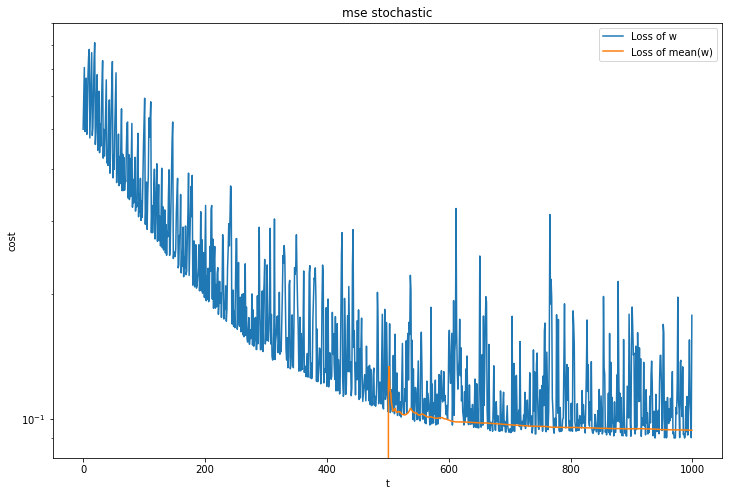

In [27]:
w, all_w, pobj, avg_w, avg_pobj = stochastic_gradient(X, y, gamma, n_iter, w_ini, loss=loss, average=True, t0=500)

plt.figure(figsize=(12,8))
plt.plot(pobj, label="Loss of w")
plt.plot(avg_pobj, label="Loss of mean(w)")
plt.xlabel('t')
plt.ylabel('cost')
plt.yscale("log")
plt.legend()
plt.title('%s stochastic' % loss)
plt.show()

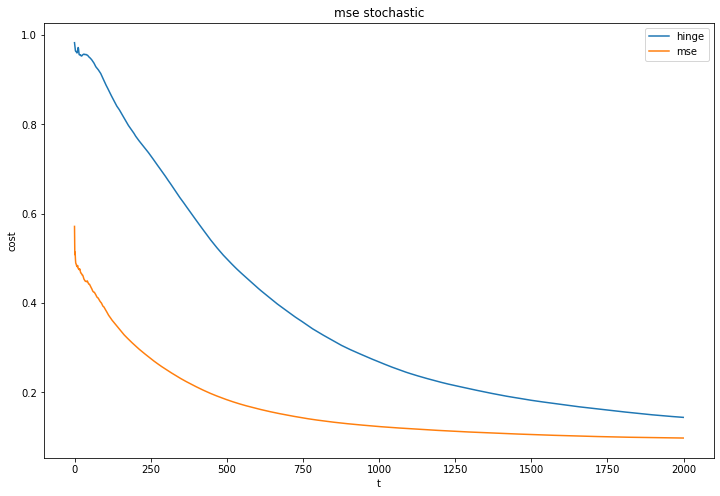

In [10]:
n_iter=2000
plt.figure(figsize=(12,8))
loss = "hinge"
gamma = 10**-2
w, all_w, pobj, avg_w, avg_pobj = stochastic_gradient(X, y, gamma, n_iter, w_ini, loss=loss, average=True)
plt.plot(avg_pobj, label=loss)
loss = "mse"
gamma = 10**-2
w, all_w, pobj, avg_w, avg_pobj = stochastic_gradient(X, y, gamma, n_iter, w_ini, loss=loss, average=True)
plt.plot(avg_pobj, label=loss)
plt.xlabel('t')
plt.ylabel('cost')
plt.legend()
plt.title('%s stochastic' % loss)
plt.show()

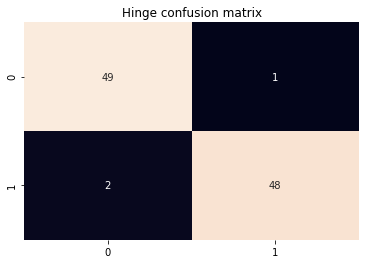

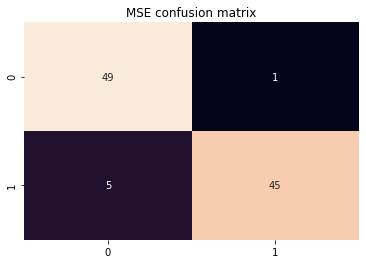

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

loss = "hinge"
gamma = 10**-2
w, all_w, pobj, avg_w, avg_pobj = stochastic_gradient(X, y, gamma, n_iter, w_ini, loss=loss, average=True)
hinge_preds = predict(X,w)
loss = "mse"
gamma = 10**-2
w, all_w, pobj, avg_w, avg_pobj = stochastic_gradient(X, y, gamma, n_iter, w_ini, loss=loss, average=True)
mse_preds = predict(X,w)

sns.heatmap(confusion_matrix(y, hinge_preds), annot=True, cbar=False)
plt.title("Hinge confusion matrix")
plt.show()

sns.heatmap(confusion_matrix(y, mse_preds), annot=True, cbar=False)
plt.title("MSE confusion matrix")
plt.show()

Comparing with SKLearn :
___***___
Models are trained on a train set and evaluated on a test set
For evaluation of our model, we select the weights that give the lowest loss on the test set
---------------------------------
On toy regression dataset :
Loss = MSE, gamma=0.01, n_iter=2000, constant learning rate, no regularization
Our model R2 :
1.0
Our model MSE :
0.0


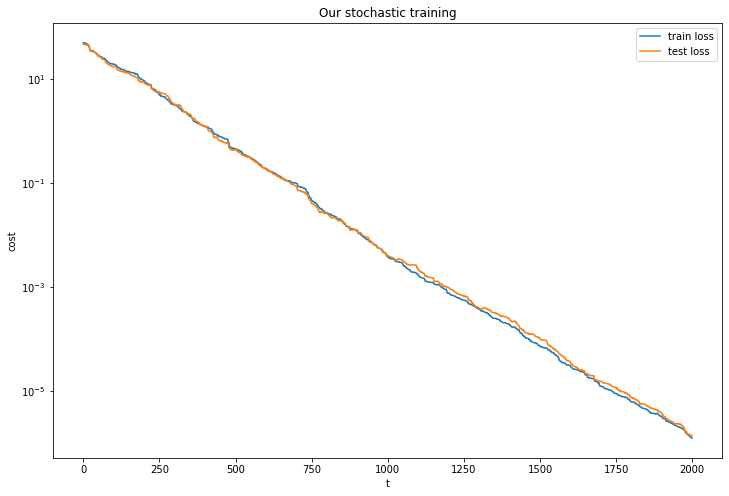

___***___
Sklearn model R2 :
1.0
Sklearn MSE :
0.0
---------------------------------
On iris dataset :
Training parameters :
Loss = hinge, gamma=0.01, n_iter=2000, constant learning rate, no regularization
Our model accuracy :
1.0


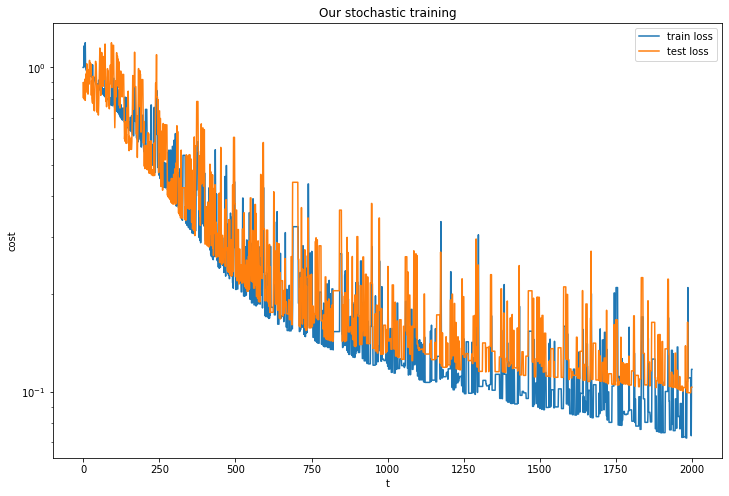

___***___
Sklearn model accuracy :
1.0


In [25]:
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, SGDRegressor

print("Comparing with SKLearn :")
print("___***___")
print("Models are trained on a train set and evaluated on a test set")
print("For evaluation of our model, we select the weights that give the lowest loss on the test set")
print("---------------------------------")
print("On toy regression dataset :")
print(f"Loss = MSE, gamma={gamma}, n_iter={n_iter}, constant learning rate, no regularization")
w_ini = np.zeros(X_toy.shape[1] + 1)
X_toy_train, X_toy_test, y_toy_train, y_toy_test = train_test_split(X_toy, y_toy, test_size=.2)
w, all_w, pobj, avg_w, avg_pobj = stochastic_gradient(X_toy_train, y_toy_train, gamma, n_iter, w_ini, loss="mse", average=True)
pobj_test = [.5*np.mean((y_toy_test-decision_function(X_toy_test, w))**2) for w in all_w]
print("Our model R2 :")
print(round(r2_score(y_toy_test, decision_function(X_toy_test, all_w[np.argmin(pobj_test)])),2))
print("Our model MSE :")
print(round(np.min(pobj_test),2))
plt.figure(figsize=(12,8))
plt.plot(pobj, label="train loss")
plt.plot(pobj_test, label="test loss")
plt.xlabel('t')
plt.ylabel('cost')
plt.yscale("log")
plt.legend()
plt.title('Our stochastic training')
plt.show()
print("___***___")
model = SGDRegressor(alpha=0,max_iter=2000,learning_rate="constant",eta0=gamma)
model.fit(X_toy_train, y_toy_train)
print("Sklearn model R2 :")
print(round(model.score(X_toy_test,y_toy_test),2))
print("Sklearn MSE :")
print(round(mean_squared_error(y_toy_test, model.predict(X_toy_test)),2))
print("---------------------------------")
print("On iris dataset :")
print("Training parameters :")
print(f"Loss = hinge, gamma={gamma}, n_iter={n_iter}, constant learning rate, no regularization")
w_ini = np.zeros(X.shape[1] + 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
w, all_w, pobj, avg_w, avg_pobj = stochastic_gradient(X_train, y_train, gamma, n_iter, w_ini, loss="hinge", average=True)
pobj_test = [np.mean(np.max((np.zeros(y_test.shape), np.ones(y_test.shape) - y_test*decision_function(X_test, w)), axis=0)) for w in all_w]
print("Our model accuracy :")
print(round(accuracy_score(y_test, predict(X_test, all_w[np.argmin(pobj_test)])),2))
plt.figure(figsize=(12,8))
plt.plot(pobj, label="train loss")
plt.plot(pobj_test, label="test loss")
plt.xlabel('t')
plt.ylabel('cost')
plt.yscale("log")
plt.legend()
plt.title('Our stochastic training')
plt.show()
print("___***___")
model = SGDClassifier(loss="hinge",alpha=0,max_iter=2000,learning_rate="constant",eta0=gamma)
model.fit(X_train, y_train)
print("Sklearn model accuracy :")
print(round(model.score(X_test,y_test),2))